In [20]:
import torch
import numpy as np
import torch.functional as F

In [8]:
def placeholder(a):
    return a


def to_one_hot(atom_num, atoms):
    atom_dict = {key: value for value, key in enumerate(atoms)}
    return F.one_hot(torch.tensor(atom_dict[atom_num]), len(atoms))


def _get_node_embeddings(mol, features=None, transforms=None):  # features: list of (name, transform pairs)
    if features is None:
        features = ['AtomicNum']
    if transforms is None:
        transforms = [placeholder]
    assert len(features) == len(transforms)
    output = []
    for atom in mol.GetAtoms():
        features_dict = {'AtomicNum': atom.GetAtomicNum()}
        output.append([transform(features_dict[feat]) for feat, transform in zip(features, transforms)])
    return torch.tensor(output)


def _get_labels(label):
    return torch.tensor(np.asarray([label]), dtype=torch.float)


def _get_edge_embeddings(mol):
    output = []

    for bond in mol.GetBonds():
        edge_features = [bond.GetBondTypeAsDouble()]
        output.extend([edge_features, edge_features])
    return torch.tensor(output, dtype=torch.float)


def _get_adjacency(mol):
    edge_indices = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices.extend([[i, j], [j, i]])
    return torch.tensor(edge_indices, dtype=torch.long).t()

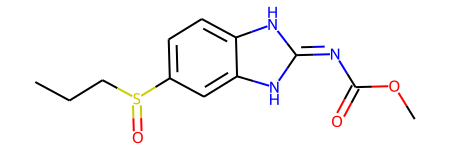

In [1]:
from rdkit import Chem

test = Chem.MolFromSmiles('CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1')

test

In [24]:
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import DataStructs
import numpy as np
import sys

np.set_printoptions(threshold=sys.maxsize)

x = GetMorganFingerprintAsBitVect(test, radius=2, nBits=1024)
y = np.frombuffer(x.ToBitString().encode(), 'u1') - ord('0')

print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

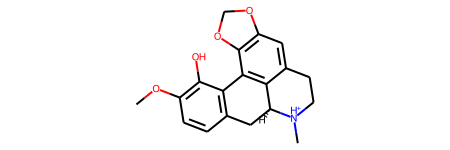

In [25]:
Chem.MolFromSmiles("C[NH+]1CCc2cc3c(c-4c2[C@@H]1Cc5c4c(c(cc5)OC)O)OCO3")

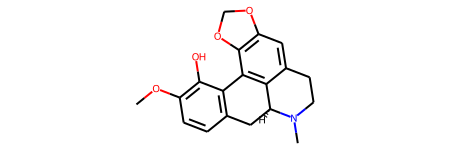

In [26]:
Chem.MolFromSmiles("CN1CCc2cc3c(c-4c2[C@@H]1Cc5c4c(c(cc5)OC)O)OCO3")

# ZINC .smi to .csv

In [30]:
import pandas as pd
import h5py
from rdkit.Chem import MolToSmiles

filename = "../../Data/zynth-templates/zinc_stock.hdf5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])

inchi = pd.read_hdf(filename, key='table')
inchi = list(np.squeeze(inchi.values))

Keys: <KeysViewHDF5 ['table']>


In [7]:
from rdkit.Chem import SmilesMolSupplier, Draw, MolToSmiles

filename = "../../Data/Zinc/raw/16_p0.smi"
molecules = SmilesMolSupplier(filename)
for i, mol in enumerate(molecules):
    try:
        Draw.MolToFile(mol, f'../../Data/Zinc/preprocessed/samples/{MolToSmiles(mol)}.png')
    except:
        pass
    if i >= 50:
        break

In [12]:
import pandas as pd
import json


with open('../../Data/Uspto/raw/uspto-templates.json') as f:
    d = json.load(f)
    df = pd.DataFrame(d)
    df = df[df['reaction_smarts'].notna()].drop(['reaction_id', 'necessary_reagent'], axis=1)
df

reactants intra_only  \
0        Cl-[S;H0;D4;+0:1](-[C:2])(=[O;D1;H0:3])=[O;D1;...      False   
1        Cl-[S;H0;D4;+0:1](-[C;D1;H3:2])(=[O;D1;H0:3])=...      False   
2        Cl-[S;H0;D4;+0:1](-[C:2])(=[O;D1;H0:3])=[O;D1;...      False   
3        Cl-[S;H0;D4;+0:1](-[C:2])(=[O;D1;H0:3])=[O;D1;...      False   
4        Cl-[S;H0;D4;+0:1](-[C;D1;H3:2])(=[O;D1;H0:3])=...      False   
...                                                    ...        ...   
1808171  Br-[c;H0;D3;+0:1](:[c:2]):[c:3].O-B(-O)-[c;H0;...      False   
1808172  Br-[c;H0;D3;+0:1](:[c:2]):[c:3].[c:4]:[nH;D2;+...      False   
1808173  Br-[c;H0;D3;+0:1](:[c:2]):[c:3].[c:4]:[nH;D2;+...      False   
1808174  Br-[c;H0;D3;+0:1](:[c:2]):[c:3]:[cH;D2;+0:4]:[...      False   
1808175  Br-[c;H0;D3;+0:1](:[c:2]):[c:3]:[cH;D2;+0:4]:[...      False   

                                                  products  \
0        [C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C:2])(=[...   
1        [C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C;D1;H3:...   
2        [C:2]-[S;H0;D4;+0:1](=[O;D1;H0:3])(=[O;D1;H0:4...   
3        [C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C:2])(=[...   
4        [C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C;D1;H3:...   
...                                                    ...   
1808171  [#16;a:7]:[c:6]:[c;H0;D3;+0:4](:[c:5])-[c;H0;D...   
1808172  [c:2]:[c;H0;D3;+0:1](:[c:3])-[n;H0;D3;+0:5](:[...   
1808173  [c:2]:[c;H0;D3;+0:1](:[c:3])-[n;H0;D3;+0:5](:[...   
1808174  [c:2]:[cH;D2;+0:1]:[c:3]:[c;H0;D3;+0:4](:[c:5]...   
1808175  [c:2]:[cH;D2;+0:1]:[c:3]:[c;H0;D3;+0:4](:[c:5]...   

                                           reaction_smarts dimer_only  
0        [C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C:2])(=[...      False  
1        [C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C;D1;H3:...      False  
2        [C:2]-[S;H0;D4;+0:1](=[O;D1;H0:3])(=[O;D1;H0:4...      False  
3        [C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C:2])(=[...      False  
4        [C:5]-[O;H0;D2;+0:6]-[S;H0;D4;+0:1](-[C;D1;H3:...      False  
...                                                    ...        ...  
1808171  [#16;a:7]:[c:6]:[c;H0;D3;+0:4](:[c:5])-[c;H0;D...      False  
1808172  [c:2]:[c;H0;D3;+0:1](:[c:3])-[n;H0;D3;+0:5](:[...      False  
1808173  [c:2]:[c;H0;D3;+0:1](:[c:3])-[n;H0;D3;+0:5](:[...      False  
1808174  [c:2]:[cH;D2;+0:1]:[c:3]:[c;H0;D3;+0:4](:[c:5]...      False  
1808175  [c:2]:[cH;D2;+0:1]:[c:3]:[c;H0;D3;+0:4](:[c:5]...      False  

[1693178 rows x 5 columns]

In [28]:
import pandas as pd

test = next(pd.read_csv('../../Data/Zinc/processed/zinc7_morgan.csv', chunksize=1000))
with open('../../Data/Zinc/processed/test_zinc7_morgan.csv', 'wb') as f:
    test.to_csv(f, index=False)

In [29]:
test2 = pd.read_csv('../../Data/Zinc/processed/test_zinc7_morgan.csv', chunksize=300)
for x in test2:
    print(x.shape)

(300, 2)
(300, 2)
(300, 2)
(100, 2)


In [15]:
import pandas as pd

with open('../../Data/Zinc/processed/_zinc7_morgan.csv', 'r') as f:
    print(f.readline())
    print(repr(f.readline()))

SMILES,BitString

'CCN(CC)C(=O)COc1ccc(cc1OC)CC=C,00010000000010000000000000000000010000000000000000000000000000000000000000000000100000000000001000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000001000000100000000000000000000010001010000000000000000000000000000000000000000000010000000000000001000000000000000000000000000000010000000000000100000000000000000000000000000000000000000000000000000010000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000010100000000000000000000000000100000000000000000000000000000000000000000001100000000000000000000100000000010001000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000001000000010000000000000000000000000100000100000000000100000000000000000000000000000000000000100000001001001000

In [14]:
df = pd.read_csv('../../Data/Zinc/processed/zinc7_morgan.csv')
df.to_csv('../../Data/Zinc/processed/_zinc7_morgan.csv', index=False)

In [1]:
import pandas as pd
df = pd.read_excel('../../Data/SAC/hartenfeller.xls')
df['smirks'].to_csv('../../Data/SAC/hartenfeller-smirks.csv', index=False)

In [2]:
!pip install xlrd

In [8]:
import re
import pandas as pd

with open('../../Data/SAC/princeton.sdf', 'r') as f:
    store = []
    b = False
    for line in f.readlines():
        if b:
            store.append(line.replace('\n', ''))
        if 'smiles' in line.lower():
            b = True
        else:
            b = False

pd.DataFrame({'SMILES': store}).to_csv('../../Data/SAC/chemdiv_bb.csv', index=False, sep=',')
df = pd.read_csv('../../Data/SAC/chemdiv_bb.csv')
df.to_csv('../../Data/SAC/chemdiv_bb.csv', index=False)

In [2]:
import pandas as pd

df = pd.read_csv('../../Data/SAC/chemdiv_bb.csv')
df

SMILES
0             CCCCCc(cc1)cnc1-c(cc1)ccc1C(O)=O
1               CCN(CC)CCNc1ccnc2cc3ccccc3cc12
2               Nc(cc1)ccc1-c1nc(cccc2)c2[nH]1
3                                    Nc1nonc1N
4      N#CCCN(CCN1CCCC1)S(c1cccc2nsnc12)(=O)=O
...                                        ...
74672                     NCc1cn(Cc2ccccc2)cn1
74673                     NCc1nn(Cc2ccccc2)cn1
74674                     NCc1cn(CC2CCOCC2)nc1
74675                     NCc1cn(CC2CCOCC2)cn1
74676                     NCc1nn(CC2CCOCC2)cn1

[74677 rows x 1 columns]

In [2]:
from rdkit.Chem.rdChemReactions import ReactionFromSmarts
from rdkit.Chem import MolFromSmiles
from tqdm import tqdm
import pandas as pd


rxns = [ReactionFromSmarts(smirks) for smirks in pd.read_csv('../../Data/SAC/hartenfeller-smirks.csv')['smirks']]
for rxn in rxns:
    rxn.Initialize()
smiles = pd.read_csv('../../Data/SAC/chemdiv_bb.csv')
print(smiles.shape)

(68685, 1)


In [21]:
for smi in tqdm(smiles['SMILES']):
    mask = [rxn.IsMoleculeReactant(MolFromSmiles(smi)) for rxn in rxns]
    if sum(mask) == 0:
        smiles = smiles[smiles.SMILES != smi]

print(smiles.shape)

100%|██████████| 74541/74541 [11:02<00:00, 112.48it/s]

(68685, 1)


In [4]:
smiles.drop_duplicates(inplace=True)
smiles

SMILES
0             CCCCCc(cc1)cnc1-c(cc1)ccc1C(O)=O
1               CCN(CC)CCNc1ccnc2cc3ccccc3cc12
2               Nc(cc1)ccc1-c1nc(cccc2)c2[nH]1
3                                    Nc1nonc1N
4      N#CCCN(CCN1CCCC1)S(c1cccc2nsnc12)(=O)=O
...                                        ...
68680                     NCc1cn(Cc2ccccc2)cn1
68681                     NCc1nn(Cc2ccccc2)cn1
68682                     NCc1cn(CC2CCOCC2)nc1
68683                     NCc1cn(CC2CCOCC2)cn1
68684                     NCc1nn(CC2CCOCC2)cn1

[66826 rows x 1 columns]

In [5]:
smiles.to_csv('../../Data/SAC/chemdiv_bb.csv', index=False)

In [1]:
import pandas as pd

pd.read_csv('../../Data/Moses/moses_v1.csv')

SMILES  SPLIT
0          CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1  train
1            CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1  train
2          CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1   test
3             Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO  train
4                Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C  train
...                                           ...    ...
1936957                      N#Cc1c(Br)cnc(N)c1Br  train
1936958        COC(=O)c1cc(CNC(=O)OC(C)(C)C)ccc1C  train
1936959                    NC(=O)c1ccc2ccccc2c1Br  train
1936960  CC(=O)Nc1cccc(-c2nc3cc(C)ccc3[nH]c2=O)c1  train
1936961   CC(NC(=O)OC(C)(C)C)c1nc(CO)nn1Cc1ccccc1  train

[1936962 rows x 2 columns]

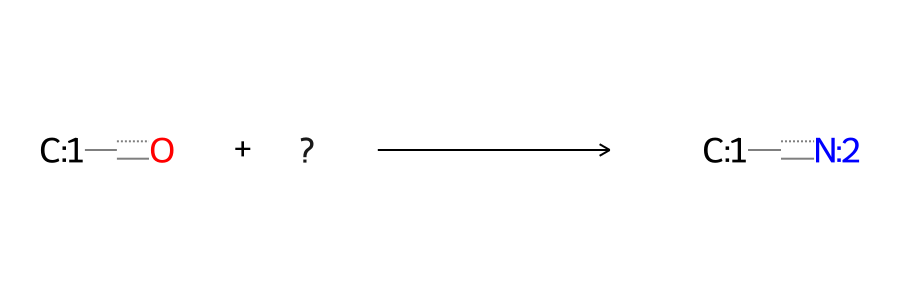

[#6:6]-[C;R0:1](=[OD1])-[CH1;R0:5](-[#6:7])-[*;#17,#35,#53].[NH2:2]-[C:3]=[SD1:4]>>[c:1]2(-[#6:6]):[n:2]:[c:3]:[s:4][c:5]([#6:7]):2


In [36]:
from rdkit.Chem import Draw, AllChem
%matplotlib inline
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdChemReactions as Reactions
from rdkit.Chem.Draw import IPythonConsole
from PIL import Image
import pickle


import pandas as pd

reactions = pd.read_csv('../../Data/SAC/hartenfeller-smirks.csv')['smirks']

route = {"product": "Cc1cccc(Cn2nnc(C(=O)N(c3ccc4c(c3)C(=O)NC4=O)c3ccccc3-c3nc4c(ccc5ccccc54)o3)c2-c2ccccc2)c1", "reaction": "[C&$(C=O):1][O&H1].[N&$(N[#6])&!$(N=*)&!$([N&-])&!$(N#*)&!$([N&D3])&!$([N&D4])&!$(N[O,N])&!$(N[C,S]=[S,O,N]):2]>>[C:1][N&+0:2]", "reactants": ["Cc1cccc(Cn2nnc(C(O)=O)c2-c2ccccc2)c1", {"product": "O=C1NC(=O)c2cc(Nc3ccccc3-c3nc4c(ccc5ccccc54)o3)ccc21", "reaction": "[Cl,Br,I][c&$(c1:[c,n]:[c,n]:[c,n]:[c,n]:[c,n]:1):1].[N;$(NC)&!$(N=*)&!$([N&-])&!$(N#*)&!$([N&D3])&!$([N&D4])&!$(N[c,O])&!$(N[C,S]=[S,O,N]),H2&$(Nc1:[c,n]:[c,n]:[c,n]:[c,n]:[c,n]:1):2]>>[c:1][N:2]", "reactants": ["Clc(cccc1)c1-c1nc(c2ccccc2cc2)c2o1", "Nc(cc1)cc(C(N2)=O)c1C2=O"]}]}

smirk = reactions.iloc[6]
rxn = Reactions.ReactionFromSmarts(smirk)

d = Draw.MolDraw2DSVG(900, 300)
d.DrawReaction(ReactionFromSmarts(route['reaction']))
d.FinishDrawing()
svg = d.GetDrawingText()
svg2 = svg.replace('svg:','')
svg3 = SVG(svg2)
display(svg3)
print(smirk)

r1, r2, r3, p2 = MolFromSmiles('Cc1cccc(Cn2nnc(C(=O)N(c3ccc4c(c3)C(=O)NC4=O)c3ccccc3-c3nc4c(ccc5ccccc54)o3)c2-c2ccccc2)c1'), MolFromSmiles('Nc1cncc2ccccc12'), MolFromSmiles('Nc(cc1)cc(C(N2)=O)c1C2=O'), MolFromSmiles('O=C1NC(=O)c2cc(Nc3ccccc3-c3nc4c(ccc5ccccc54)o3)ccc21')
Draw.MolToFile(r1, '../../figures/reactions/model_product.svg')
Draw.MolToFile(r2, '../../figures/reactions/model_reactant2.svg')
Draw.MolToFile(r3, '../../figures/reactions/model_reactant3.svg')
Draw.MolToFile(p2, '../../figures/reactions/model_subproduct.svg')


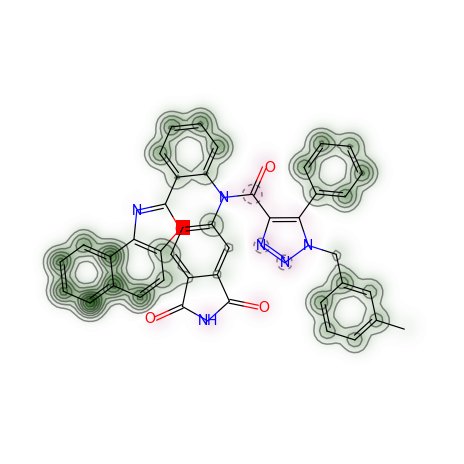

In [42]:
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem


from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from IPython.display import SVG
import io
from PIL import Image
import numpy as np
import rdkit


mol = Chem.MolFromSmiles('Cc1cccc(Cn2nnc(C(=O)N(c3ccc4c(c3)C(=O)NC4=O)c3ccccc3-c3nc4c(ccc5ccccc54)o3)c2-c2ccccc2)c1')
refmol = Chem.MolFromSmiles('CCCN(CCCCN1CCN(c2ccccc2OC)CC1)Cc1ccc2ccccc2c1')
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol, SimilarityMaps.GetMorganFingerprint)



d = Draw.MolDraw2DSVG(500, 500)
_, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(refmol, mol,
                                                             lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='bv'),
                                                             draw2d=d)
d.FinishDrawing()

svg = d.GetDrawingText()
svg2 = svg.replace('svg:','')
svg3 = SVG(svg2)
display(svg3)

In [12]:
from rdkit.Chem import Draw, AllChem
%matplotlib inline
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

rxn = AllChem.ReactionFromSmarts('[CH3:1][C:2](=[O:3])[OH:4].[CH3:5][NH2:6]>CC(O)C.[Pt]>[CH3:1][C:2](=[O:3])[NH:6][CH3:5].[OH2:4]',useSmiles=True)
d = Draw.MolDraw2DSVG(900, 300)
d.DrawReaction(rxn)
d.FinishDrawing()

# rxn = AllChem.ReactionFromSmarts('[CH3:1][C:2](=[O:3])[OH:4].[CH3:5][NH2:6]>CC(O)C.[Pt]>[CH3:1][C:2](=[O:3])[NH:6][CH3:5].[OH2:4]',useSmiles=True)
# colors=[(0.3,0.7,0.9),(0.9,0.7,0.9),(0.6,0.9,0.3),(0.9,0.9,0.1)]
# d = Draw.MolDraw2DSVG(900, 300)
# d.DrawReaction(rxn,highlightByReactant=True,highlightColorsReactants=colors)
# d.FinishDrawing()

# txt = d.GetDrawingText()
# self.assertTrue(txt.find("<svg") != -1)
# self.assertTrue(txt.find("</svg>") != -1)

"<?xml version='1.0' encoding='iso-8859-1'?>\n<svg version='1.1' baseProfile='full'\n              xmlns='http://www.w3.org/2000/svg'\n                      xmlns:rdkit='http://www.rdkit.org/xml'\n                      xmlns:xlink='http://www.w3.org/1999/xlink'\n                  xml:space='preserve'\nwidth='800px' height='200px' viewBox='0 0 800 200'>\n<!-- END OF HEADER -->\n<rect style='opacity:1.0;fill:#FFFFFF;stroke:none' width='800.0' height='200.0' x='0.0' y='0.0'> </rect>\n<path class='bond-0 atom-0 atom-1' d='M 175.9,135.3 L 161.3,119.9' style='fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1' />\n<path class='bond-0 atom-0 atom-1' d='M 179.4,127.6 L 169.1,116.8' style='fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;stroke-dasharray:6,6' />\n<path class='bond-8 atom-8 atom-0' d='M 215.0,133.9 L 189.1,140.2' style='fill:none;fill-rule